In [1]:
import random
from dtw import dtw
import numpy
import cv2 
import matplotlib.pyplot as plt

euclidean = lambda img1, img2 : numpy.sqrt(numpy.sum((img1-img2)**2))

def dynamic_time_warping(img1, img2):
    
    img1 = img1 * 255.0/float(img1.max())
    img2 = img2 * 255.0/float(img2.max())
    dist, cost, acc_cost, path = dtw(img1, img2, dist=euclidean)
    return dist

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 # library needs to be installed first: conda install -c conda-forge opencv

# Take a page number as input
# Return an array with the corresponding Id as the first argument 
# and the cropped image(word with white background) as numpy array as the second argument
# e.g. [['70-01-01', array([[255, 255, 255, ..., 207, 207, 206],
#                           [255, 255, 255, ..., 208, 208, 255],
#                           [255, 255, 255, ..., 207, 208, 255],
#                           ...,
#                           [255, 255, 255, ..., 255, 255, 255],
#                           [255, 255, 255, ..., 255, 255, 255],
#                           [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)],
#       ... ]
def loadWordsFromTestPage(page_number):
    path_ground_truth = "ground-truth/locations/" + str(page_number) + ".svg"
    path_image = "images/" + str(page_number) + ".jpg"
    
    allCoordinates = []
    
    with open(path_ground_truth, "r") as paths:
        for line in paths :
            coordinates = []
            if "path" in line :
                startIndexCoordinate = line.find("M") + 1
                endIndexCoordinate = line.find("Z")

                startIndexId = line.find("id=") + 4
                endIndexId = startIndexId + 9

                substringCoordinates = line[startIndexCoordinate: endIndexCoordinate]
                coordinateStrings = re.findall("\d+\.\d+", substringCoordinates)

                substringId = line[startIndexId: endIndexId]

                index = 0
                for i in range(int(len(coordinateStrings)/2)):
                    coordinates.append([float(coordinateStrings[index]), float(coordinateStrings[index+1])])
                    index += 2   
                allCoordinates.append([substringId, coordinates]) 
                
    prepared_words_images = []
    
    img = Image.open(path_image)
    img = np.array(img)
    
    for wordCoordinates in allCoordinates:
        clone = img.copy() 

        contours = [np.array(wordCoordinates[1], dtype=np.int32)]
        mask = np.ones_like(clone)*255
        cv2.drawContours(mask,contours,0,0,-1)
        out = np.ones_like(clone)*255
        out[mask == 0] = clone[mask == 0]

        (x, y) = np.where(mask == 0)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        out = out[topx:bottomx+1, topy:bottomy+1]
        out[out>170] = 255
        prepared_words_images.append([wordCoordinates[0], out])

    return prepared_words_images
    

def load_train_word(splittedKeyword):
    path = "ground-truth/locations/" + splittedKeyword[2] + ".svg"
    path_image = "images/" + splittedKeyword[2] + ".jpg"
    
    allCoordinates = []
    
    with open(path, "r") as paths:
        for line in paths :
            coordinates = []
            if "path" in line :
                startIndexCoordinate = line.find("M") + 1
                endIndexCoordinate = line.find("Z")

                startIndexId = line.find("id=") + 4
                endIndexId = startIndexId + 9

                substringCoordinates = line[startIndexCoordinate: endIndexCoordinate]
                coordinateStrings = re.findall("\d+\.\d+", substringCoordinates)

                substringId = line[startIndexId: endIndexId]
                
                if substringId == splittedKeyword[1]:
                    index = 0
                    for i in range(int(len(coordinateStrings)/2)):
                        coordinates.append([float(coordinateStrings[index]), float(coordinateStrings[index+1])])
                        index += 2   
                    allCoordinates.append([substringId, coordinates, splittedKeyword[0]])  
                    
    prepared_words_images = []
    
    img = Image.open(path_image)
    img = np.array(img)

    for wordCoordinates in allCoordinates:
        clone = img.copy() 

        contours = [np.array(wordCoordinates[1], dtype=np.int32)]
        mask = np.ones_like(clone)*255
        cv2.drawContours(mask,contours,0,0,-1)
        out = np.ones_like(clone)*255
        out[mask == 0] = clone[mask == 0]

        (x, y) = np.where(mask == 0)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        out = out[topx:bottomx+1, topy:bottomy+1]
        out[out>170] = 255
        prepared_words_images.append([wordCoordinates[0], out, wordCoordinates[2]])

    return prepared_words_images
    
    

In [6]:
import string
test_path = 'task/test.txt'
keywords_path = 'task/keywords.txt'

def read_pages_numbers(directory):
    f = open(directory, 'r')
    x = f.readlines()
    pages = [w.replace('\n', '') for w in x] # replace trailing sign of new line end of the string
    f.close()
    return pages

def read_keywords(path):
    keywords = []
    with open(path, 'r') as f:
        for line in f:
            split = line.split(',')
            keywords.append([split[0], split[1].replace('\n', ''), (split[1].split('-'))[0]])
    return keywords        
            

def load_testdata(path_to_pagenumbers):
    pages = read_pages_numbers(path_to_pagenumbers)
    images = []
    for i in range(len(pages)):
        pagenum = (int)(pages[i])
        print('Loading images from page', pagenum)
        for word in loadWordsFromTestPage(pagenum):
            images.append(word)
    print('length is ' + str(len(images)))
    print("---------------------------------------")
    return images

def load_traindata(keywords_path):
    keywords = read_keywords(keywords_path)
    images = []
    for keyword in keywords:
        print('Loading images from page', keyword[2])
        for word in load_train_word(keyword):
            images.append(word)
    print('length is ' + str(len(images)))
    print("---------------------------------------")
    return images    

In [7]:
keyword_images = load_traindata(keywords_path)

Loading images from page 271
Loading images from page 271
Loading images from page 272
Loading images from page 300
Loading images from page 271
Loading images from page 271
Loading images from page 273
Loading images from page 273
Loading images from page 274
Loading images from page 276
length is 10
---------------------------------------


In [9]:
test_images = load_testdata(test_path)

Loading images from page 305
Loading images from page 306
Loading images from page 307
Loading images from page 308
Loading images from page 309
length is 1167
---------------------------------------


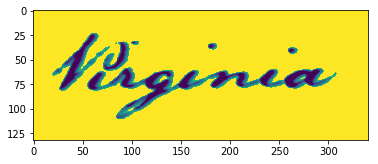

In [10]:
plt.imshow(keyword_images[0][1])

In [17]:
from sys import stdout

def getDistance(keyword_images, test_images):
    result = {}
    for keyword_image in keyword_images:
        img1 = cv2.resize(keyword_image[1], dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
        distances = []
        i = 1
        message = ""
        for test_image in test_images:
            stdout.write("\r")
            last_message = message
            message = "Comparing " + keyword_image[2] + " with test word id " + test_image[0] + " (remaining: " + str(len(test_images)-i) + ")"
            stdout.write('{message: <{fill}}'.format(message=message, fill=str(len(last_message))))
            
            img2 = cv2.resize(test_image[1], dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
            distance = dynamic_time_warping(img1, img2)
            distances.append([test_image[0], distance])
            
            stdout.flush()
            i += 1
        distances.sort(key=lambda x: x[1])    
        result[keyword_image[2]] = distances    
    return result

In [28]:
def saveResult(result):
    with open('handwriting_results.txt', 'w+') as f:
        for k, v in result.items():
            f.write(str(k))
            for value in v:
                f.write(", " + str(value[0]) + ", " + str(value[1]))
            f.write("\n")    

In [19]:
result = getDistance(keyword_images, test_images)

Comparing R-e-c-r-u-i-t-s with test word id 309-36-02 (remaining: 0)   

In [30]:
for k, v in result.items():
    print(len(v))

1167
1167
1167
1167
1167
1167
1167
1167
1167
1167


In [29]:
saveResult(result)